In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
tf.reset_default_graph()

rnn_unit=32
lstm_layers=2     
input_size=40
output_size=1
lr=0.001        

f=open('train_data.csv')
df=pd.read_csv(f)    
train=df.iloc[:,3:10].values  
volume=df.iloc[:,5].values
train = np.delete(train,2,axis = 1)
train = np.delete(train,2,axis = 1)
train = np.delete(train,3,axis = 1)
for i in range(len(train)):
    train[i][2] = math.log(train[i][2]/train[i][3],10)
    if i > 0:
        train[i][1] = train[i][1]-train[i-1][1]
    else:
        train[i][1] = 0
    train[i][3] = math.log(volume[i],10)
f2=open('test_data.csv')
df2=pd.read_csv(f2)
test=df2.iloc[:,3:10].values
test = np.delete(test,2,axis = 1)
test = np.delete(test,2,axis = 1)
test = np.delete(test,3,axis = 1)
volume_test=df2.iloc[:,5].values
for i in range(len(test)):
    test[i][2] = math.log(test[i][2]/test[i][3],10)
    if i > 0:
        test[i][1] = test[i][1]-test[i-1][1]
    else:
        test[i][1] = 0
    test[i][3] = math.log(volume_test[i],10)
train_date = df.iloc[:,1].values

In [111]:
def get_train_data(batch_size = 2000, time_step = 1):
    batch_index=[]
    normalized_train_data=(train-train_mean)/train_std  #标准化
    train_x,train_y=[],[]   #训练集
    i = 0
    j = 0
    while(i < len(normalized_train_data)-time_step-30):
        if train_date[i] != train_date[i+29]:
            i += 29
        if j % batch_size == 0:
            batch_index.append(j)
        x = np.reshape(normalized_train_data[i:i+10,:4],[1,40])
        y = np.reshape(np.mean(normalized_train_data[i+10:i+30,0]),[1,1])
        now = x[0][36]
        goal = y[0][0]
        dif = goal - now
        dif = np.reshape(dif,[1,1])
        train_x.append(x.tolist())
        train_y.append(dif.tolist())
        i += 1
        j += 1
    batch_index.append(j-30-time_step-1)
    return batch_index,train_x,train_y

In [112]:
def get_test_data(time_step=1):
    normalized_test_data=(test-test_mean)/test_std  #标准化
    test_x = []
    for i in range(1000):
        x=np.reshape(normalized_test_data[i*10:(i+1)*10,:4],[1,40])
        test_x.append(x.tolist())
    return test_x

In [113]:
def get_test_data2(time_step=1):
    normalized_test_data=(train-train_mean)/train_std  #标准化
    test_x = []
    for i in range(40000):
        x=np.reshape(normalized_test_data[i*10:(i+1)*10,:4],[1,40])
        test_x.append(x.tolist())
    return test_x

In [114]:
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }
keep_prob = tf.placeholder(tf.float32, name='keep_prob') 

In [115]:
def lstmCell():
    #basicLstm单元
    basicLstm = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    # dropout
    drop = tf.nn.rnn_cell.DropoutWrapper(basicLstm, output_keep_prob=keep_prob)
    return basicLstm

In [116]:
train_mean = np.mean(train,axis = 0)
train_std = np.std(train,axis = 0)
test_mean = np.mean(test,axis = 0)
test_std = np.std(test,axis = 0)

In [117]:
def lstm(X):
    
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell = tf.nn.rnn_cell.MultiRNNCell([lstmCell() for i in range(lstm_layers)])
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [118]:
def train_lstm(batch_size=2000,time_step=1):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size,time_step)
    with tf.variable_scope("sec_lstm"):
        pred,_=lstm(X)
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(100):     
            for step in range(len(batch_index)-2):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]],keep_prob:0.5})
            print("Number of iterations:",i," loss:",loss_)
        print("model_save: ",saver.save(sess,'model_save2\\modle.ckpt'))
        print("The train has finished")
train_lstm()

Number of iterations: 0  loss: 0.00023751889
Number of iterations: 1  loss: 0.0001182758
Number of iterations: 2  loss: 9.2945236e-05
Number of iterations: 3  loss: 8.270611e-05
Number of iterations: 4  loss: 7.727167e-05
Number of iterations: 5  loss: 7.4577765e-05
Number of iterations: 6  loss: 7.3959614e-05
Number of iterations: 7  loss: 7.45029e-05
Number of iterations: 8  loss: 7.486249e-05
Number of iterations: 9  loss: 7.444311e-05
Number of iterations: 10  loss: 7.376858e-05
Number of iterations: 11  loss: 7.322986e-05
Number of iterations: 12  loss: 7.284465e-05
Number of iterations: 13  loss: 7.2460425e-05
Number of iterations: 14  loss: 7.1964176e-05
Number of iterations: 15  loss: 7.137222e-05
Number of iterations: 16  loss: 7.060538e-05
Number of iterations: 17  loss: 6.956339e-05
Number of iterations: 18  loss: 6.83818e-05
Number of iterations: 19  loss: 6.763967e-05
Number of iterations: 20  loss: 6.782424e-05
Number of iterations: 21  loss: 6.833503e-05
Number of iterat

INFO:tensorflow:Restoring parameters from model_save2\modle.ckpt


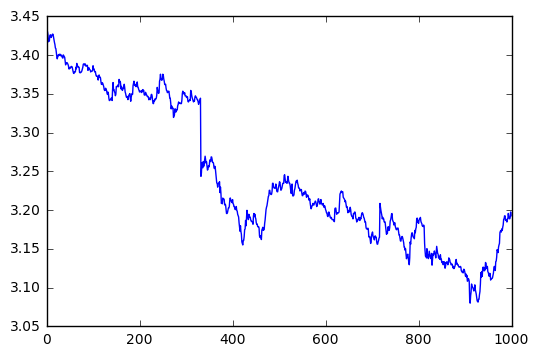

In [173]:
def prediction(time_step=1):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    test_x=get_test_data(time_step)
    with tf.variable_scope("sec_lstm",reuse=tf.AUTO_REUSE):
        pred,_=lstm(X)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #参数恢复
        module_file = tf.train.latest_checkpoint('model_save2')
        saver.restore(sess, module_file)
        test_predict=[]
        for step in range(len(test_x)):
            prob=sess.run(pred,feed_dict={X:[test_x[step]],keep_prob:1})
            predict=prob.reshape((-1))
            test_predict.extend(predict)
        big = test_predict
        for i in range(len(test_predict)):
            test_predict[i] = ((test_x[i][0][36]+test_predict[i]*0.5)*test_std[0]+test_mean[0])
        test_predict = np.array(test_predict)
        xx = []
        for i in range(len(test_predict)):
            xx.append(i)
            if abs(test_predict[i] - (test_x[i][0][36]*test_std[0]+test_mean[0])) > 0.002:
                test_predict[i] = (test_x[i][0][36]*test_std[0]+test_mean[0])*0.95+test_predict[i]*0.05
        plt.figure()
        plt.plot(xx, test_predict, color='b')
        plt.show()
    return test_predict,big

ans,big= prediction()

In [155]:
import csv
data = []
for i in range(142,1000):
    temp = []
    temp.append(i+1)
    temp.append(ans[i])
    data.append(temp)
with open('ans.csv','w',newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['caseid','midprice'])
    for list in data:
        csv_writer.writerow(list)